In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pandas.io.sql as sqlio
from datetime import date
import psycopg2 as ps
from helpers import connectors
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(20,10)})
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})
sns.set_style("darkgrid")

# SQL connection

In [2]:
con = connectors.DWHGlovoConnection().create_conn()

# Query

In [3]:
cb_query = '''
select distinct o.customer_id,
                date_trunc('day', o.creation_time) :: date                                 as order_creation,
                date_trunc('day', fpce.created_at) :: date                                 as cb_creation,
                CASE
                    WHEN reason like '%processing%' or reason = '12.6' or reason = '4860' or reason = '13.6' or
                         reason = '4834' THEN 'payment_issue'
                    WHEN reason like '%consumer%' or reason = '4853' or reason = '13.1' THEN 'refund_dispute'
                    WHEN reason like '%fraud%' or reason = '4837' or reason = '10.4' THEN 'fraud'
                    ELSE 'blank'
                    END                                                                    AS cb_codes,
                fpce.invoice_id,
                o.ordering_payment_method,
                o.final_status,
                -fpce.amount_eur                                                           as amount_eur,
                o.gtv / o.exchange_rate_currency                                           as gtv_eur,
                o.store_address_id,
                o.vertical,
                o.category,
                fpce.market_country,
                o.city_code,
                o.first_order,
                o.description,
                o.handling_strategy_type,
                o.total_delivery_time_minutes,
                nullif(json_extract_path_text(features, 'ravelin', 'score'), ' '):: int    as ravelin_score,
                nullif(json_extract_path_text(features, 'ravelin', 'action'), ' ') :: text as ravelin_action,
                nullif(json_extract_path_text(features, 'payment_method', 'country'),
                       ' ') :: text                                                        as cc_country,
                -- fingerprint de la tarjeta
                nullif(json_extract_path_text(features, 'payment_method', 'cardFingerprint'),
                       ' ') :: text                                                        as payment_card_hash,
                nullif(json_extract_path_text(features, 'payment_method', 'cardLastFourDigits'),
                       ' ') :: bigint                                                      as payment_card_last_four,
                nullif(json_extract_path_text(features, 'payment_method', 'cardBin'),
                       ' ') :: bigint                                                      as payment_card_bin,
                nullif(json_extract_path_text(features, 'payment_method', 'nameOnCard'),
                       ' ') :: varchar                                                     as payment_card_name,
                p.card_provider                                                            as card_provider,
                -- age in seconds
                nullif(json_extract_path_text(features, 'payment_method', 'creationTime'),
                       ' ') :: bigint                                                      as payment_creation,
                -- customer age in seconds
                nullif(json_extract_path_text(features, 'customer', 'creationTime'),
                       ' ') :: bigint                                                      as cus_creation_time,
                nullif(json_extract_path_text(features, 'customer', 'name'),
                       ' ') :: varchar                                                     as cus_name,
                nullif(json_extract_path_text(features, 'customer', 'ordersCount'),
                       ' ') :: int                                                         as ordersCount,
                min(nullif(json_extract_path_text(features, 'customer', 'deliveredOrdersCount'),
                           ' ') :: int) OVER (PARTITION BY o.customer_id)                  as orderscountdelivered,
                nullif(json_extract_path_text(features, 'customer', 'ordersCountInLast30Days'),
                       ' ') :: int                                                         as ordersCountInLast30Days,
                min(nullif(json_extract_path_text(features, 'customer', 'ordersCountInLast90Days'),
                           ' ') :: int) OVER (PARTITION BY o.customer_id)                  as ordersCountInLast90Days,
                json_extract_path_text(features, 'customer', 'email')                      as email,
                json_extract_path_text(features, 'customer', 'phoneNumber')                as phone,
                -- geohash
                nullif(json_extract_path_text(features, 'order', 'pickupPoint', 'h3AddressResolution9'),
                       ' ') :: text                                                        as h3_pickup,
                nullif(json_extract_path_text(features, 'order', 'deliveryPoint', 'h3AddressResolution9'),
                       ' ') :: text                                                        as h3_delivery
from orders o
         join fraud_po_chargeback_events fpce on o.id = fpce.order_id
         join checkout_order co on co.order_id = o.id
         join payments p on p.order_id = o.id
         join risk_feature_snapshots rfs
              on nullif(json_extract_path_text(features, 'order', 'checkoutId'), ' ') = cast(co.checkout_id as text)
where 1 = 1
  and o.creation_time >='2022-07-01'
  and o.country_code = 'IT'
  and fpce.type = 'transaction.chargeback.created'
  and o.ordering_payment_method in ('CREDIT_CARD', 'GOOGLE_PAY', 'APPLE_PAY');
'''

In [4]:
df = pd.read_sql_query(cb_query, con)

/Users/mingyi.zeng/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df = df.drop_duplicates(subset=['invoice_id'])

In [6]:
df['order_creation'] = pd.to_datetime(df['order_creation'])
df['cb_creation'] = pd.to_datetime(df['cb_creation'])
df['cb_week'] = df['cb_creation'].dt.isocalendar().week
df['cb_week'] = df['cb_week'].fillna(0).astype(int)
df = df[df['cb_week'] != 0].reset_index()

In [7]:
df['delta_order_cb'] = (df['cb_creation'] - df['order_creation']).dt.days

In [8]:
counts = df.groupby('cb_week').count().reset_index()
unique = df.groupby('cb_week').nunique().reset_index()
sums = df.groupby('cb_week').sum().reset_index()
means = df.groupby('cb_week').mean().reset_index()

# General Overview

## CB amount in euros per week + amount of CB per week

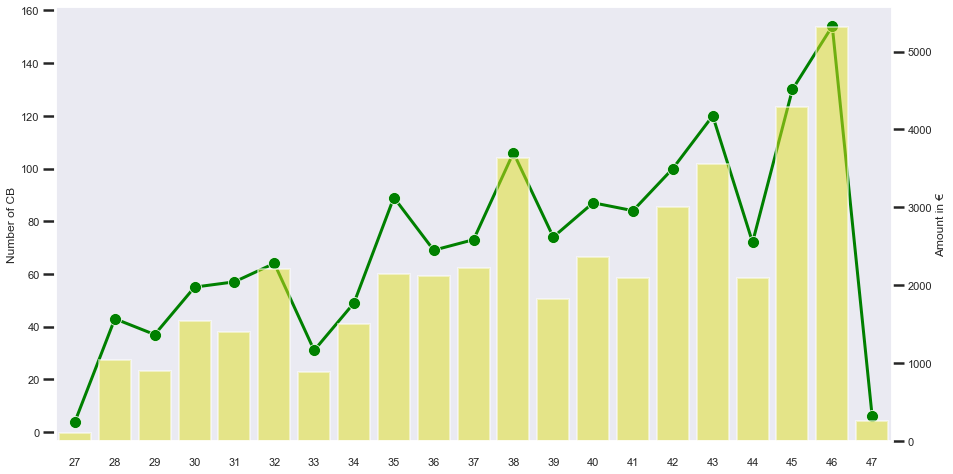

In [9]:
fig, ax1 = plt.subplots(figsize=(15,8))
plt.xticks(range(df['cb_week'].max()-10, df['cb_week'].max()));
ax2 = plt.twinx()
ax1.set_ylabel(r"Number of CB")
ax2.grid(False)
ax1.grid(False)
sns.lineplot(data=unique['invoice_id'], color="green", marker='o', sort = False, ax=ax1)
sns.barplot(data=sums, x='cb_week', y='amount_eur', color="yellow", ax=ax2, alpha=0.5).set_ylabel(r"Amount in €");

## Unique customers per week

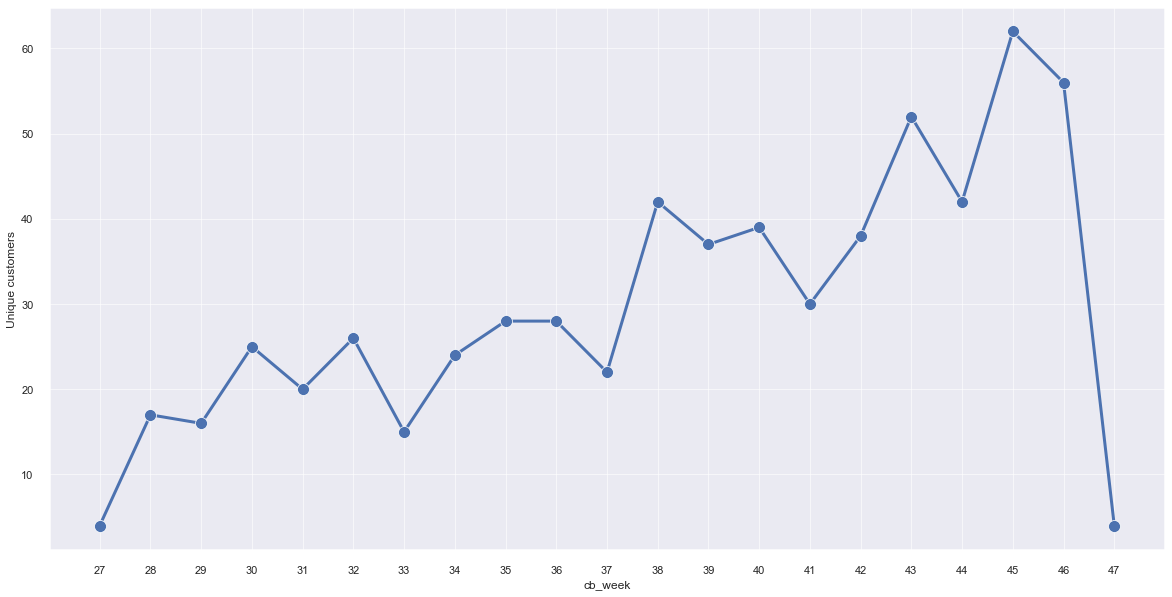

In [10]:
sns.lineplot(data=unique, x='cb_week', y='customer_id', marker='o').set_ylabel(r"Unique customers")
plt.xticks(range(df['cb_week'].min(), df['cb_week'].max() + 1));

## Average CB amount per week

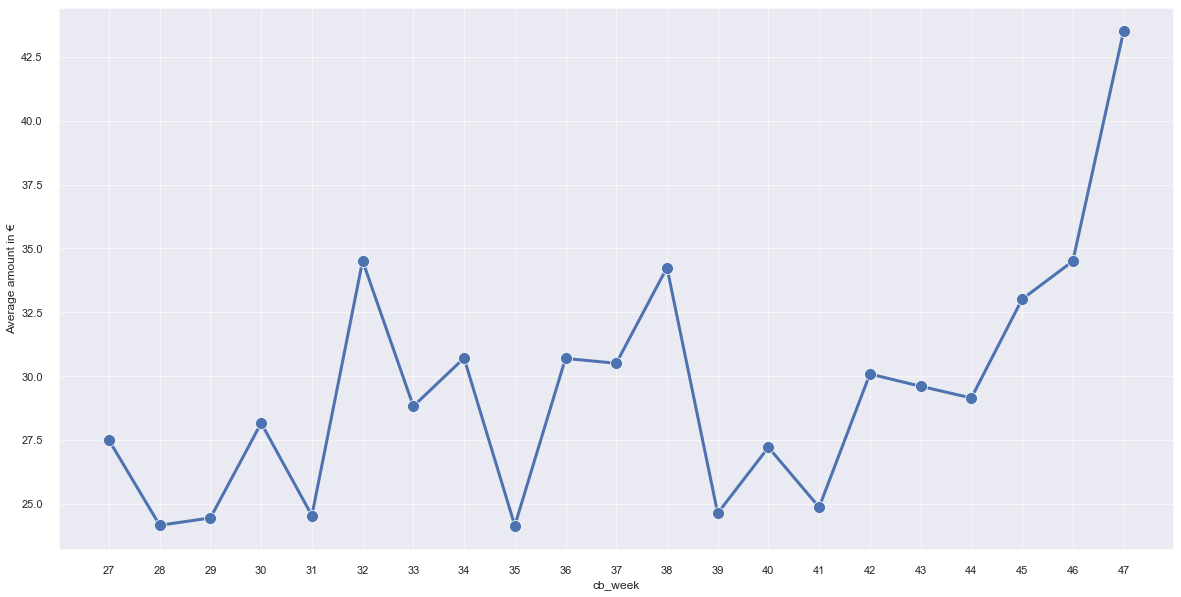

In [11]:
sns.lineplot(data=means, x='cb_week', y='amount_eur', marker='o').set_ylabel(r"Average amount in €")
plt.xticks(range(df['cb_week'].min(), df['cb_week'].max() + 1));

## Average number of days since order and CB

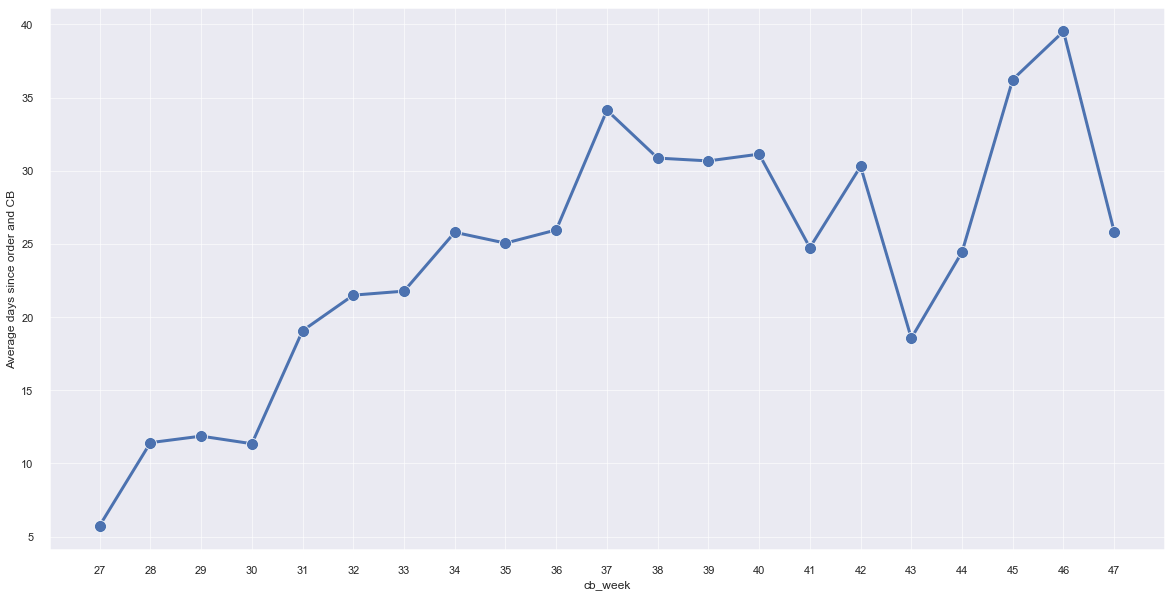

In [12]:
sns.lineplot(data=means, x='cb_week', y='delta_order_cb', marker='o').set_ylabel(r"Average days since order and CB")
plt.xticks(range(df['cb_week'].min(), df['cb_week'].max() + 1));

# Cards

## CC Country

In [13]:
cc_country = df.groupby(['cb_week', 'cc_country']).filter(lambda x: x['customer_id'].count() > 10)
cc_country1 = cc_country.groupby(['cb_week', 'cc_country']).sum().reset_index()

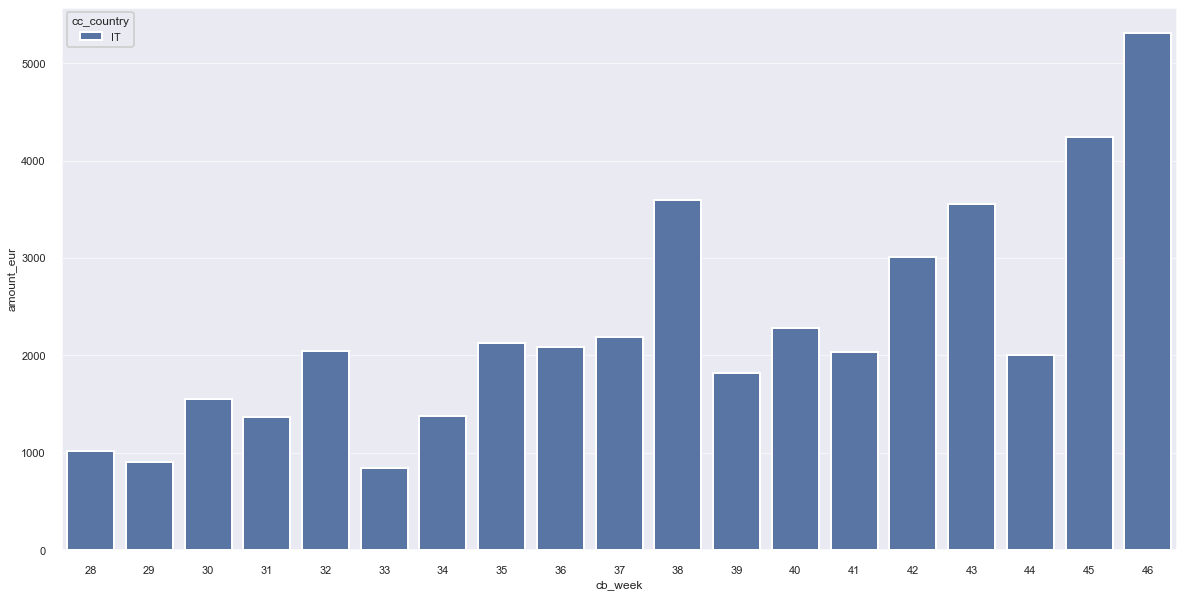

In [14]:
sns.barplot(data=cc_country1, x='cb_week', y='amount_eur', hue='cc_country');

## CC BINs

### Number of different bins per week

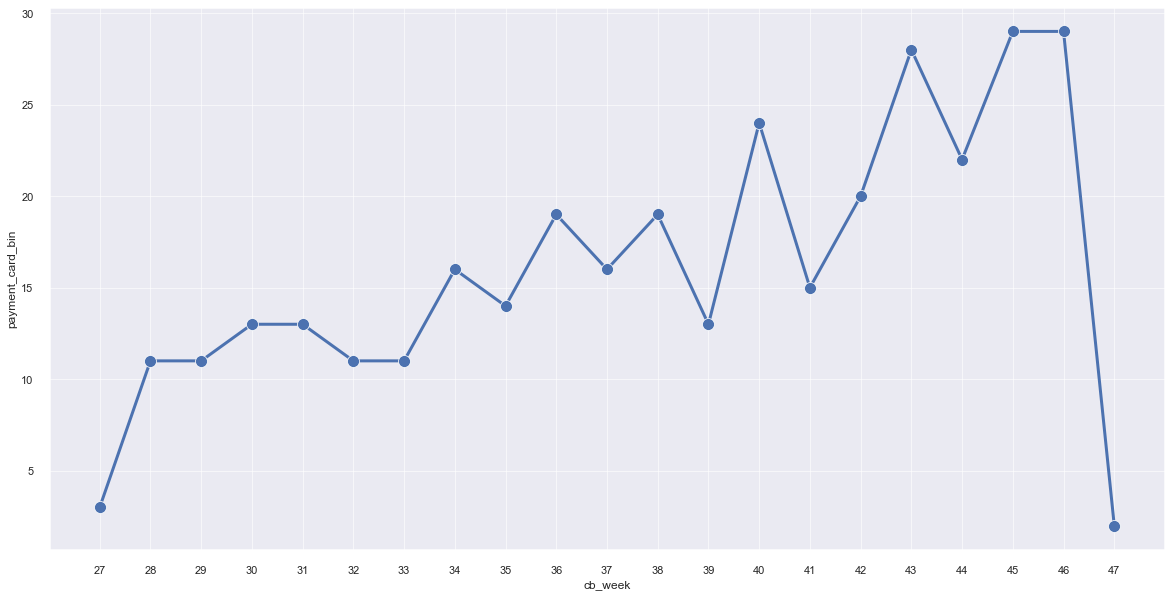

In [15]:
sns.lineplot(x='cb_week', y='payment_card_bin', data=unique, marker='o')
plt.xticks(range(df['cb_week'].min(), df['cb_week'].max() + 1));

### Top BINs

In [16]:
bins = df.groupby('cb_week')['payment_card_bin'].value_counts().rename('count').reset_index(level='payment_card_bin')
bins.nlargest(10, 'count')

,payment_card_bin,count
cb_week,,
41,533317.0,44
39,533317.0,34
38,533317.0,33
32,533317.0,32
42,533317.0,31
43,453997.0,31
46,453997.0,31
35,533317.0,27
45,533317.0,23


## Card provider

In [17]:
provider = df.groupby(['cb_week', 'card_provider']).sum().reset_index()

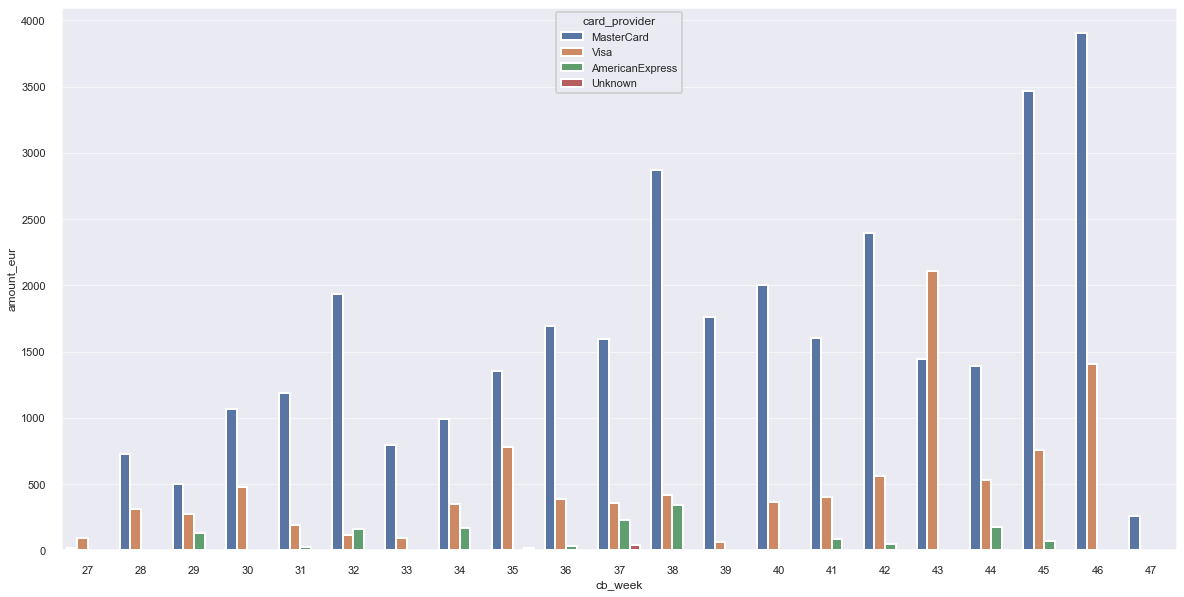

In [18]:
sns.barplot(data=provider, x='cb_week', y='amount_eur', hue='card_provider');

# Stores

## Number of different stores per week

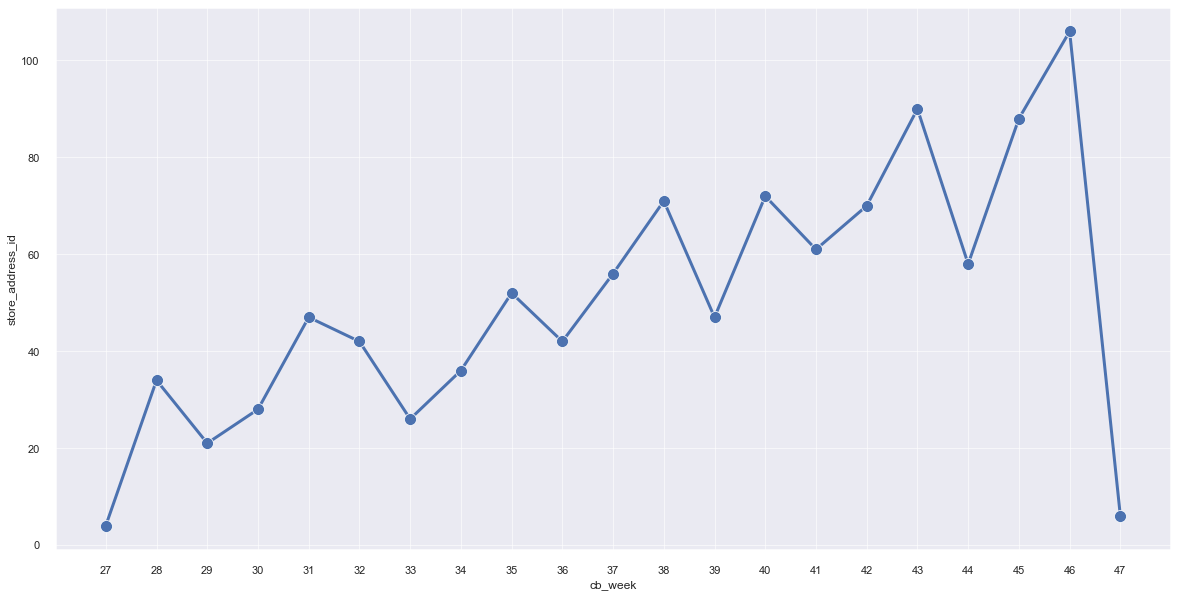

In [19]:
sns.lineplot(data=unique, x='cb_week', y='store_address_id', marker='o')
plt.xticks(range(df['cb_week'].min(), df['cb_week'].max()+1));

## Verticals

In [20]:
vertical = df.groupby(['cb_week', 'vertical']).agg('sum').reset_index()

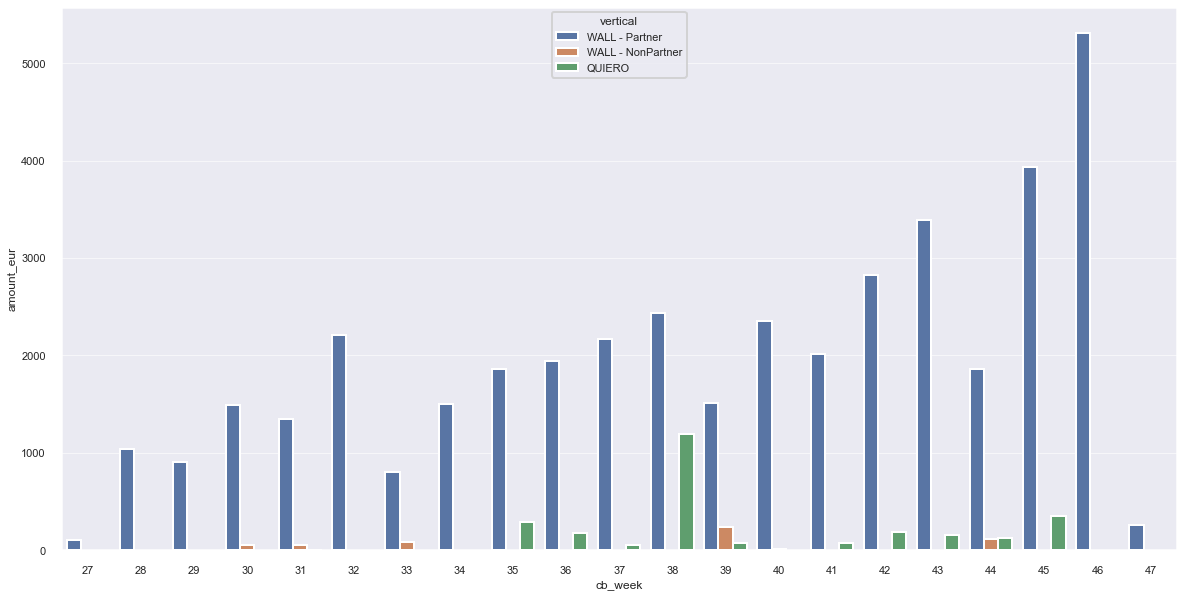

In [21]:
sns.barplot(data=vertical[vertical['cb_week'] > 13], x='cb_week', y='amount_eur', hue="vertical");

## Categories

In [22]:
cat = df.groupby(['cb_week', 'category']).agg('sum').reset_index()
cat = cat[cat['amount_eur'] >= cat['amount_eur'].median()]

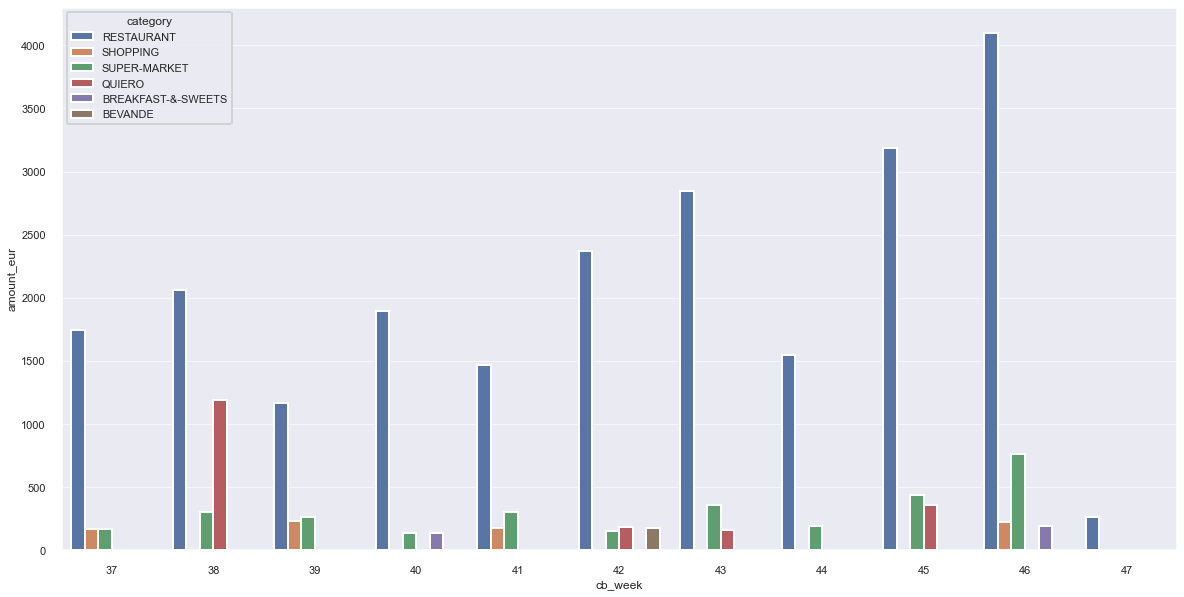

In [23]:
sns.barplot(data=cat[cat['cb_week'] >= cat['cb_week'].max() - 10], x='cb_week', y='amount_eur', hue="category");

### TOP customers in Risky Categories

In [24]:
top_risky_categories = list(df[(df['cb_week'] >= df['cb_week'].max()-5)&(df['category'] != 'RESTAURANT')].groupby(['category']).agg('sum').reset_index().nlargest(6, 'amount_eur')['category'])

In [25]:
for category in top_risky_categories:
    cat_df = df[(df['cb_week'] >= df['cb_week'].max()-5) & (df['category'] == f"{category}")].groupby(['cb_week', 'customer_id']).sum().sort_values(['cb_week', 'amount_eur'], ascending=False).reset_index().nlargest(10, 'amount_eur').loc[:, ['cb_week', 'customer_id', 'amount_eur']]
    print(f"Top 10 customers with {category} chargebacks in the last 5 weeks:")
    display(cat_df)
    print('\n')

Top 10 customers with SUPER-MARKET chargebacks in the last 5 weeks:


,cb_week,customer_id,amount_eur
0,46,22259053,632.82
6,45,88768636,272.76
17,43,109146224,155.16
7,45,130184473,117.44
18,43,57068016,86.51
10,44,67055539,57.83
19,43,126717,53.21
1,46,135466437,51.14
23,42,58977170,50.94
11,44,128039516,41.03




Top 10 customers with QUIERO chargebacks in the last 5 weeks:


,cb_week,customer_id,amount_eur
0,45,115670250,266.47
6,42,88012234,184.97
4,43,52513460,138.88
3,44,57402625,124.99
1,45,22492132,59.39
2,45,108634108,29.28
5,43,12154014,22.47




Top 10 customers with SHOPPING chargebacks in the last 5 weeks:


,cb_week,customer_id,amount_eur
0,46,22259053,146.87
3,45,88768636,86.37
8,42,88012234,58.47
5,44,747088,56.49
1,46,134719300,56.08
6,44,124814123,55.00
7,43,65493805,46.96
4,45,2021154,43.46
2,46,130605918,23.73




Top 10 customers with BREAKFAST-&-SWEETS chargebacks in the last 5 weeks:


,cb_week,customer_id,amount_eur
0,46,130605918,150.45
3,45,43733292,56.08
6,44,30897222,35.88
9,42,131536957,34.40
7,43,47957119,29.99
4,45,42221958,27.19
1,46,134685983,26.99
8,43,11868370,21.00
2,46,14851236,15.20
5,45,43678830,14.62




Top 10 customers with BEVANDE chargebacks in the last 5 weeks:


,cb_week,customer_id,amount_eur
1,44,42530465,83.75
2,42,51730043,70.60
3,42,132647204,53.70
4,42,88012234,53.21
0,46,130605918,25.88




Top 10 customers with PHARMACY chargebacks in the last 5 weeks:


,cb_week,customer_id,amount_eur
0,43,65493805,89.91
1,42,88012234,25.49


# Customers

## Orders in the last 90 days

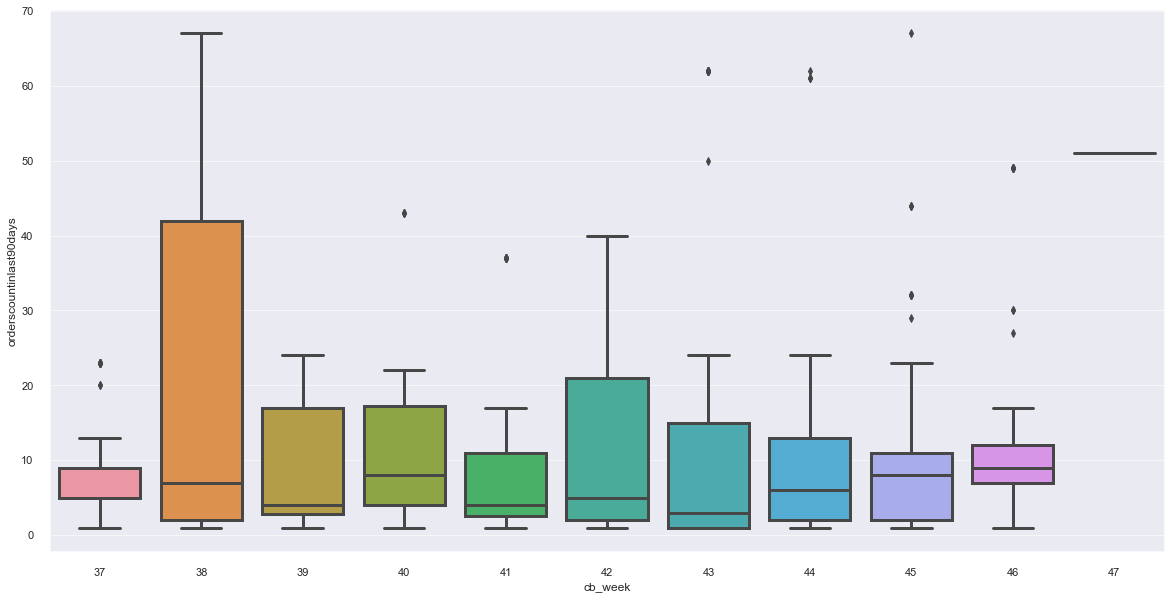

In [26]:
sns.boxplot(x='cb_week', y='orderscountinlast90days', data=df[(df['orderscountinlast90days'].between(1, 100)) & (df['cb_week'] >= df['cb_week'].max()-10)]);

## First orders

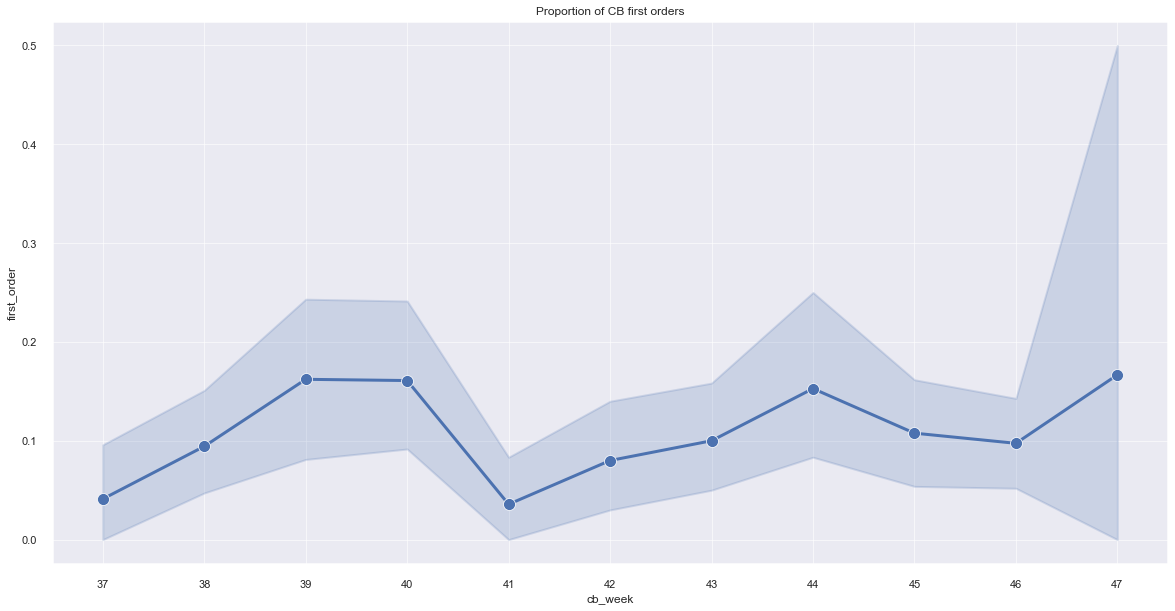

In [27]:
sns.lineplot(x='cb_week', y='first_order', data=df[df['cb_week'] >= df['cb_week'].max()-10], marker='o').set(title='Proportion of CB first orders')
plt.xticks(range((df['cb_week'].max()-10), df['cb_week'].max()+1));

## Chargeback segmentation

In [28]:
df['order_creation'] = pd.to_datetime(df['order_creation'])
df['cb_creation'] = pd.to_datetime(df['cb_creation'])
df['cb_week'] = df['cb_creation'].dt.isocalendar().week
df['cb_week'] = df['cb_week'].fillna(0).astype(int)
#df['payment_creation'] = df['payment_creation'].fillna(0)
#df['payment_creation'] = df['payment_creation'].astype(int)
df['payment_creation_date'] = [pd.to_datetime(x, unit='ms') if len(str(x)) >= 11 else pd.to_datetime(x, unit='s') for x in df['payment_creation']]
df['customer_registration_date'] = [pd.to_datetime(x, unit='ms') if len(str(x)) >= 11 else pd.to_datetime(x, unit='s') for x in df['cus_creation_time']]
df = df[df['cb_week'] != 0].reset_index()

In [29]:
df['delta_order_cb'] = (df['cb_creation'] - df['order_creation']).dt.days

In [30]:
df['delta_registration_order'] = (df['order_creation']-df['payment_creation_date']).dt.days
df['delta_registration_order'].mask(df['delta_registration_order'] >= 2700, 0, inplace=True)

In [31]:
df['delta_registration_order'] = df['delta_registration_order'].fillna(200)

In [32]:
df['delta_cust_registration_first_order_cb'] = (df['order_creation'] - df['customer_registration_date']).dt.days
delta_reg_cb = pd.DataFrame(df.groupby('customer_id')['delta_cust_registration_first_order_cb'].min())
delta_reg_cb.reset_index(inplace=True)
df = df.merge(delta_reg_cb, how='left')

In [33]:
# number of chargebacks by customer
num_cb = pd.DataFrame(df.groupby('customer_id').count()['index'])
num_cb.rename(columns={'index': 'num_cb'}, inplace=True, errors='raise')
num_cb.reset_index(inplace=True)
df = df.merge(num_cb, how='left')

In [34]:
# minimum days between payment method registration and order creation
payment_order = pd.DataFrame(df.groupby('customer_id').min()['delta_registration_order'])
payment_order.reset_index(inplace=True)
df = df.merge(payment_order, how='left')

/var/folders/6y/qzgdpb415rq2vz6jdph2xgg80000gp/T/ipykernel_38700/3374829703.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  payment_order = pd.DataFrame(df.groupby('customer_id').min()['delta_registration_order'])


In [35]:
# delta between first and last cb order creation, add as new column of main df
delta = pd.DataFrame(df.groupby('customer_id')['order_creation'].max()-df.groupby('customer_id')['order_creation'].min())
delta.rename(columns={'order_creation': 'order_creation_delta'}, inplace=True, errors='raise')
delta.reset_index(inplace=True)
df = df.merge(delta, how='left')

In [36]:
# previous orders at the first chareback
prev_ord = pd.DataFrame(df.groupby('customer_id').min()['orderscount'])
prev_ord.rename(columns={'orderscount': 'orders_count'}, inplace=True, errors='raise')
prev_ord.reset_index(inplace=True)
df = df.merge(prev_ord, how='left')

/var/folders/6y/qzgdpb415rq2vz6jdph2xgg80000gp/T/ipykernel_38700/2918329558.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  prev_ord = pd.DataFrame(df.groupby('customer_id').min()['orderscount'])


In [37]:
# max chargebacks in a day
max_cb = pd.DataFrame(df.groupby(['customer_id', 'order_creation']).count()['index'])
max_cb.rename(columns={'index': 'max_cb_day'}, inplace=True, errors='raise')
max_cb.reset_index(inplace=True)
max_cb = max_cb.groupby('customer_id').max().reset_index()
max_cb.drop('order_creation', axis=1, inplace=True)
df = df.merge(max_cb, how='left', left_on='customer_id', right_on='customer_id')

In [38]:
df['cb_rate_customer'] = df['num_cb'] / df['orderscountdelivered']
df.replace([np.inf, -np.inf], 1, inplace=True)

In [39]:
# number of chargebacks by customer
num_cb = pd.DataFrame(df.groupby('customer_id').count()['index'])
num_cb.rename(columns={'index': 'num_cb'}, inplace=True, errors='raise')
num_cb.reset_index(inplace=True)
df = df.merge(num_cb, how='left')

In [40]:
# delta between first and last cb order creation, add as new column of main df
delta = pd.DataFrame(df.groupby('customer_id')['order_creation'].max()-df.groupby('customer_id')['order_creation'].min())
delta.rename(columns={'order_creation': 'order_creation_delta'}, inplace=True, errors='raise')
delta.reset_index(inplace=True)
df = df.merge(delta, how='left')

In [41]:
df['card_non_domestic'] = ~np.array(list((df['market_country'] == df['cc_country']) & (~df['cc_country'].isnull())))
df[df['ordering_payment_method'] != 'CREDIT_CARD'].loc[:, 'card_non_domestic'] = ~df[df['ordering_payment_method'] != 'CREDIT_CARD'].loc[:, 'card_non_domestic']

/var/folders/6y/qzgdpb415rq2vz6jdph2xgg80000gp/T/ipykernel_38700/3392756054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['ordering_payment_method'] != 'CREDIT_CARD'].loc[:, 'card_non_domestic'] = ~df[df['ordering_payment_method'] != 'CREDIT_CARD'].loc[:, 'card_non_domestic']


# payment method registration > 6 months

In [42]:
conditions = [
    # account age                                          # velocity                                                                                             # no previous orders                # new cards with no good history                                              # older accounts with very high cb proportion
    ((df['delta_cust_registration_first_order_cb'] <= 7) | ((df['max_cb_day'] >= 3) & (df['orderscountdelivered'] <= 5) & (df['delta_registration_order'] <= 7)) | (df['orderscountdelivered'] == 0) | ((df['delta_registration_order'] <= 7) & (df['orderscountdelivered'] <= 5)) | ((df['delta_cust_registration_first_order_cb'] <= 30) & (df['cb_rate_customer'] > 0.5)))\
      # dormant accounts                                                                                                                                                     # ato
    | ((df['delta_cust_registration_first_order_cb'] >= 150) & (df['delta_registration_order'] >= 150) & (df['card_non_domestic']) & (df['orderscountinlast90days'] <= 6) & (df['num_cb'] >= 1)) |
    ((df['delta_cust_registration_first_order_cb'] >= 150) &  (df['delta_registration_order'] <= 7) & (df['orderscountinlast90days'] <= 6) & (df['num_cb'] >= 1)) & (df['card_non_domestic']),
    ((df['delta_cust_registration_first_order_cb'] >= 120) & (df['orderscountdelivered'] >= 5)) | ((df['delta_registration_order'] >= 120) & (df['orderscountdelivered'] >= 5) & (df['num_cb'] >= 3)),
    ((df['num_cb'] <=2) & (df['orderscountdelivered'] >= 2) & (df['delta_cust_registration_first_order_cb'] >= 120))
]
values = ['cc_fraud', 'friendly_fraud', 'non_fraud']
df['segments'] = np.select(conditions, values, default='other')
seg = list(df.groupby(['customer_id', 'segments']).count().reset_index().loc[:, ['customer_id', 'segments', 'index']].to_records(index=False))
result = dict()
for key1, key2, value in seg:
    result.setdefault(key1, {}).update({key2: value})
for x in result:
    result.update({x: max(result[x], key=result[x].get)})
df['segments'] = df['customer_id'].map(result)

In [43]:
df['segments'].value_counts(normalize=True)

friendly_fraud    0.454787
cc_fraud          0.428856
other             0.095745
non_fraud         0.020612
Name: segments, dtype: float64

## Analysis by segments

In [44]:
segment = df.groupby(['cb_week', 'segments']).sum().sort_values(['cb_week', 'amount_eur'], ascending=False).reset_index()

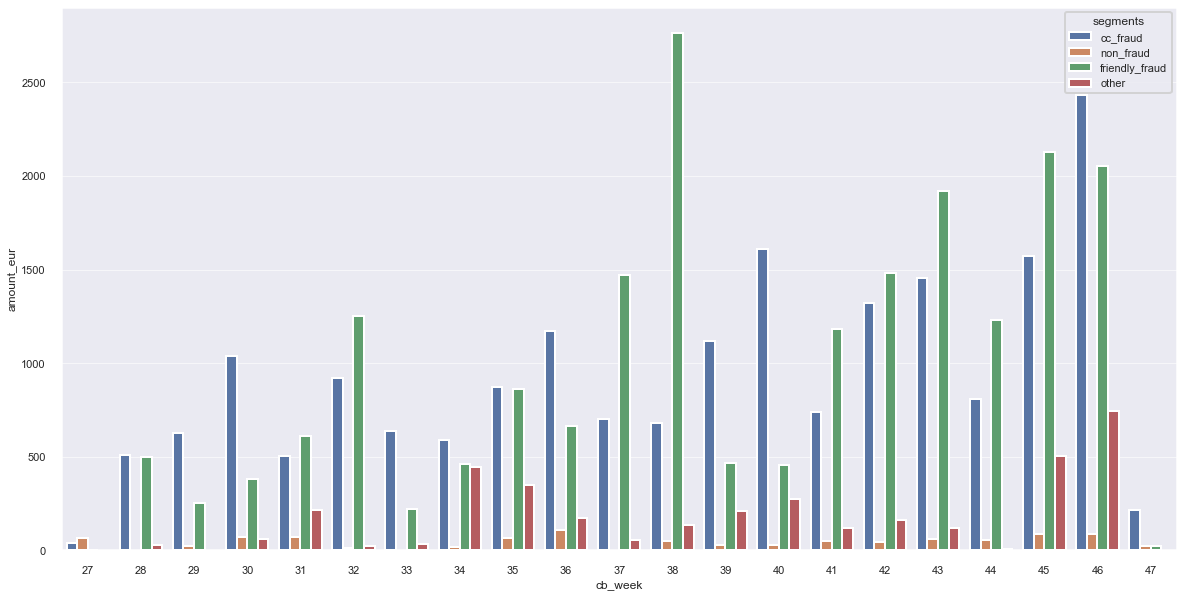

In [45]:
sns.barplot(data=segment, x='cb_week', y='amount_eur', hue='segments');

## Top customers

In [46]:
top_eur = df.groupby(['cb_week', 'customer_id']).sum() \
                             .sort_values(['cb_week', 'amount_eur'], ascending=False).reset_index()
top_count = df.groupby(['cb_week', 'customer_id']).count() \
                             .sort_values(['cb_week', 'amount_eur'], ascending=False).reset_index()

In [47]:
top = top_eur.merge(top_count, on=['customer_id', 'cb_week'], how='left')
top = top.merge(df[['customer_id', 'segments']], on='customer_id', how='left')
top = top.rename(columns={'amount_eur_x': 'total_amount', 'cb_creation': 'cb_count', 'cb_week_x': 'cb_week', 'segments_y': 'segments'})
top = top.drop_duplicates()

In [48]:
for i in range(df['cb_week'].max()-10, df['cb_week'].max()+1):
    top_week = top[top['cb_week'] == i].nlargest(20, 'total_amount').loc[:, ['customer_id', 'total_amount', 'cb_count', 'segments']]
    eur_week = df[df['cb_week'] == i]['amount_eur'].sum()
    num_cust = len(df[df['cb_week'] == i]['customer_id'].unique()) - 20
    print(f'Top 20 CB customers of week {i}')
    print(f"Amount of chargeback from the top 20 customers: €{round(top_week['total_amount'].sum(), 2)}")
    print(f"Total amount of chargeback from week {i}: €{round(eur_week, 2)}")
    print(f"Proportion of CB explained by top 20 customers: {round(top_week['total_amount'].sum()/eur_week, 2)}")
    if num_cust > 0:
        print(f"There are {num_cust} unique customers apart from the top 20")
    else:
        print(f"There are 0 unique customers apart from the top 20")
    display(top_week)
    print('\n')

Top 20 CB customers of week 37
Amount of chargeback from the top 20 customers: €2199.49
Total amount of chargeback from week 37: €2226.44
Proportion of CB explained by top 20 customers: 0.99
There are 2 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
1205,2772185,446.34,12,friendly_fraud
1217,124814123,258.80,14,cc_fraud
1232,79985137,231.29,6,friendly_fraud
1244,58608041,215.73,6,cc_fraud
1250,2668273,173.00,2,friendly_fraud
1253,28773078,159.16,6,friendly_fraud
1259,53088963,151.17,5,friendly_fraud
1264,42258049,122.46,5,friendly_fraud
1269,131451005,62.10,2,cc_fraud
1272,106634303,51.18,1,cc_fraud




Top 20 CB customers of week 38
Amount of chargeback from the top 20 customers: €3011.28
Total amount of chargeback from week 38: €3630.39
Proportion of CB explained by top 20 customers: 0.83
There are 22 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
1065,22492132,1034.30,9,friendly_fraud
1075,67262069,590.27,15,friendly_fraud
1090,79985137,254.88,6,friendly_fraud
1102,45260192,104.14,2,friendly_fraud
1104,74613648,102.34,7,other
1119,54563995,92.48,4,friendly_fraud
1123,39502642,89.49,1,friendly_fraud
1124,126968056,83.56,4,cc_fraud
1128,20590071,63.56,4,friendly_fraud
1132,129216869,63.49,3,cc_fraud




Top 20 CB customers of week 39
Amount of chargeback from the top 20 customers: €1437.62
Total amount of chargeback from week 39: €1822.31
Proportion of CB explained by top 20 customers: 0.79
There are 17 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
962,132319016,142.28,2,cc_fraud
967,27910135,138.17,8,friendly_fraud
975,126177382,123.70,9,other
984,127604262,108.09,3,cc_fraud
991,128126044,107.49,1,cc_fraud
999,127095255,106.99,1,cc_fraud
1007,132722215,88.67,4,cc_fraud
1011,130431383,79.50,2,cc_fraud
1014,131551060,65.88,2,cc_fraud
1016,13190001,59.55,3,friendly_fraud




Top 20 CB customers of week 40
Amount of chargeback from the top 20 customers: €1949.01
Total amount of chargeback from week 40: €2367.09
Proportion of CB explained by top 20 customers: 0.82
There are 19 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
835,131536957,190.82,9,cc_fraud
855,130184473,172.48,8,cc_fraud
871,123352193,153.20,5,other
876,129373823,152.89,6,cc_fraud
883,130335383,142.91,7,cc_fraud
890,13630591,131.95,3,cc_fraud
894,131911059,111.70,2,cc_fraud
896,131261686,108.33,3,cc_fraud
900,125950324,82.78,2,cc_fraud
902,132683949,81.50,4,cc_fraud




Top 20 CB customers of week 41
Amount of chargeback from the top 20 customers: €1865.77
Total amount of chargeback from week 41: €2088.45
Proportion of CB explained by top 20 customers: 0.89
There are 10 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
732,88012234,209.83,5,friendly_fraud
745,29501544,169.29,11,friendly_fraud
756,132942380,159.78,6,cc_fraud
764,43255640,141.07,8,friendly_fraud
772,114369496,131.36,8,friendly_fraud
780,131008238,119.38,2,cc_fraud
784,54848868,115.12,2,friendly_fraud
786,129237458,113.80,7,cc_fraud
793,132041938,105.77,6,cc_fraud
799,27038959,99.20,2,friendly_fraud




Top 20 CB customers of week 42
Amount of chargeback from the top 20 customers: €2490.7
Total amount of chargeback from week 42: €3008.06
Proportion of CB explained by top 20 customers: 0.83
There are 18 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
615,131536957,464.39,9,cc_fraud
635,88012234,372.18,8,friendly_fraud
648,51730043,172.00,3,friendly_fraud
651,91078646,167.41,13,friendly_fraud
664,132647204,135.09,6,cc_fraud
671,21067029,122.43,3,friendly_fraud
674,51410722,121.12,9,friendly_fraud
683,20462522,119.70,3,cc_fraud
686,133317258,84.60,1,cc_fraud
687,133317356,78.78,3,cc_fraud




Top 20 CB customers of week 43
Amount of chargeback from the top 20 customers: €2412.71
Total amount of chargeback from week 43: €3551.86
Proportion of CB explained by top 20 customers: 0.68
There are 32 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
479,126717,260.60,12,friendly_fraud
492,52513460,248.95,9,cc_fraud
501,130408270,208.50,4,cc_fraud
505,65493805,187.67,6,cc_fraud
511,109146224,155.16,4,friendly_fraud
515,56415103,144.23,7,friendly_fraud
522,44577720,124.20,2,friendly_fraud
524,57068016,123.45,3,friendly_fraud
527,108477757,115.18,6,cc_fraud
533,33113780,112.97,4,friendly_fraud




Top 20 CB customers of week 44
Amount of chargeback from the top 20 customers: €1507.23
Total amount of chargeback from week 44: €2098.19
Proportion of CB explained by top 20 customers: 0.72
There are 22 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
373,747088,159.06,5,friendly_fraud
378,133871390,135.30,2,cc_fraud
380,695103,133.47,5,friendly_fraud
385,57402625,124.99,1,friendly_fraud
387,42530465,83.75,1,friendly_fraud
388,134175747,78.60,2,cc_fraud
390,67055539,77.06,3,friendly_fraud
393,134591297,74.87,2,cc_fraud
395,27644751,68.10,1,friendly_fraud
396,30897222,64.38,3,friendly_fraud




Top 20 CB customers of week 45
Amount of chargeback from the top 20 customers: €2782.02
Total amount of chargeback from week 45: €4291.27
Proportion of CB explained by top 20 customers: 0.65
There are 42 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
202,88768636,359.13,5,friendly_fraud
207,83864165,342.28,8,other
215,115670250,266.47,3,friendly_fraud
219,130184473,191.37,8,cc_fraud
235,134635623,176.04,2,cc_fraud
237,15683348,151.95,3,friendly_fraud
240,56137830,136.14,7,other
247,134198264,121.49,3,cc_fraud
252,42221958,108.76,4,friendly_fraud
256,134043309,96.50,1,cc_fraud




Top 20 CB customers of week 46
Amount of chargeback from the top 20 customers: €4219.15
Total amount of chargeback from week 46: €5312.65
Proportion of CB explained by top 20 customers: 0.79
There are 36 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
9,22259053,971.13,15,friendly_fraud
24,131318496,760.49,17,cc_fraud
41,130605918,500.83,15,other
56,133524631,194.63,4,cc_fraud
61,2164303,179.63,13,friendly_fraud
74,134693538,159.32,2,cc_fraud
76,133961954,156.10,2,cc_fraud
78,131536957,147.65,2,cc_fraud
98,134719300,144.06,3,cc_fraud
101,6970835,125.56,8,friendly_fraud




Top 20 CB customers of week 47
Amount of chargeback from the top 20 customers: €261.01
Total amount of chargeback from week 47: €261.01
Proportion of CB explained by top 20 customers: 1.0
There are 0 unique customers apart from the top 20


,customer_id,total_amount,cb_count,segments
0,134445801,132.74,2,cc_fraud
2,134198264,82.99,2,cc_fraud
7,48805107,24.15,1,non_fraud
8,88770138,21.13,1,friendly_fraud


# Ravelin Score

## Ravelin scores over and under 50

In [49]:
df['score_over_50'] = [True if x >= 50 else False for x in df['ravelin_score']]

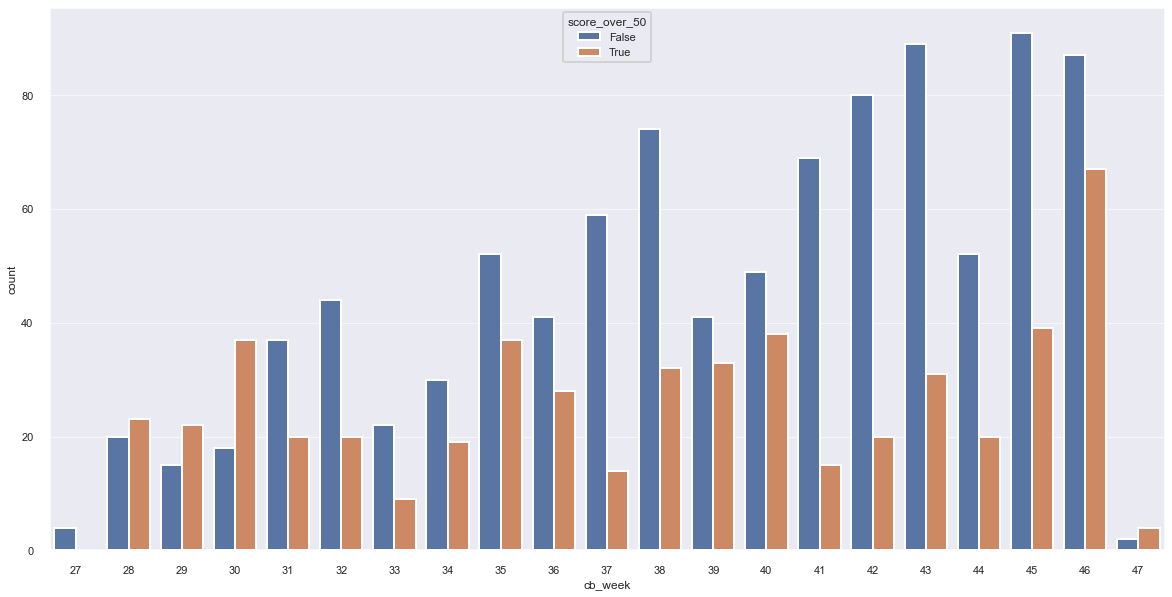

In [50]:
sns.countplot(data=df, x='cb_week', hue='score_over_50');

## Score distribution over time

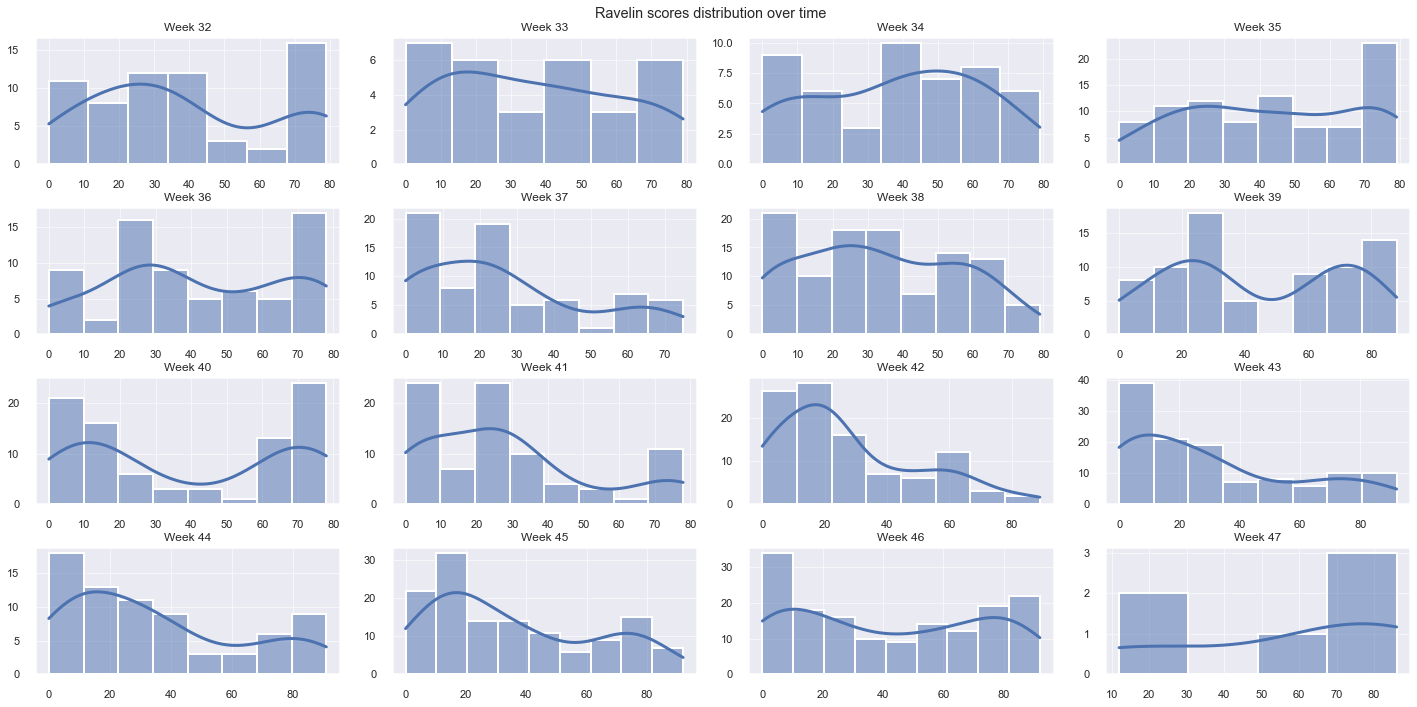

In [51]:
fig, axes = plt.subplots(ncols=4, nrows=4)
fig.suptitle('Ravelin scores distribution over time')
fig.tight_layout()

for i, ax in zip(range(df['cb_week'].max()-15, df['cb_week'].max()+1), axes.flat):
    sns.histplot(df[df['cb_week'] == i]['ravelin_score'], ax=ax, kde=True).set(title=f'Week {i}', xlabel=None, ylabel=None)
plt.show()

In [52]:
df.drop(['level_0', 'index'], axis=1, inplace=True)

In [53]:
df.to_csv('it_dataset.csv', header=True, index=False)

In [54]:
df

,customer_id,order_creation,cb_creation,cb_codes,invoice_id,ordering_payment_method,final_status,amount_eur,gtv_eur,store_address_id,vertical,category,market_country,city_code,first_order,description,handling_strategy_type,total_delivery_time_minutes,ravelin_score,ravelin_action,cc_country,payment_card_hash,payment_card_last_four,payment_card_bin,payment_card_name,card_provider,payment_creation,cus_creation_time,cus_name,orderscount,orderscountdelivered,orderscountinlast30days,orderscountinlast90days,email,phone,h3_pickup,h3_delivery,cb_week,delta_order_cb,payment_creation_date,customer_registration_date,delta_registration_order,delta_cust_registration_first_order_cb,num_cb,order_creation_delta,orders_count,max_cb_day,cb_rate_customer,card_non_domestic,segments,score_over_50
0,74613648,2022-08-09,2022-09-05,fraud,iv_Fk4OjwtVxeraCAh0BmPAx4IV7nVnBU03,CREDIT_CARD,DeliveredStatus,39.20,39.20,119704.0,WALL - Partner,RESTAURANT,IT,FGN,False,1 x 6 Chicken McNuggets - Salsa Barbecue\n1 x ...,DELIVERY,40.0000,55,ALLOW,IT,0fc0c6d290d20afb8596c69c457de64a537af0c30aae79...,172.0,525500.0,Alessandra Stoppini,MasterCard,1659878599000,1631611874000,Luca DInnocenzio,8,3,4,1,lucadinno5@gmail.com,+393348280913,891e8430827ffff,891e84356d3ffff,36,27,2022-08-07 13:23:19,2021-09-14 09:31:14,1,328,15,24 days,5,4,5.000000,False,other,True
1,130335383,2022-09-09,2022-10-08,blank,iv_hSIGeXhSMKwY43N2aQAVdnsiLFBhOA0b,CREDIT_CARD,DeliveredStatus,19.60,19.60,139418.0,WALL - Partner,RESTAURANT,IT,ROM,False,"1 x Crunchicken - Standard fries, Coca cola\n5...",DELIVERY,24.1000,18,ALLOW,IT,e69b73c4e56dce778f8784fd9b335258507954f7753e36...,113.0,671149.0,Thomas Rizzi Pretorius,MasterCard,1661281408000,1661280771000,Mario Rossi,8,8,8,8,aa0963832@gmail.com,+393511385227,891e8050303ffff,891e805035bffff,40,29,2022-08-23 19:03:28,2022-08-23 18:52:51,16,16,7,17 days,8,2,0.875000,False,cc_fraud,False
2,24182048,2022-08-05,2022-08-13,fraud,iv_cxWu3pwhzGpF0RNDR8jwCRJKc2057w05,CREDIT_CARD,DeliveredStatus,12.00,12.00,22913.0,WALL - Partner,RESTAURANT,IT,TOR,False,"1 x McMenu McChicken - McMenu® Small – Panino,...",DELIVERY,17.2166,0,ALLOW,IT,ce1d6be2f5dcf76ab6df34e3b63b9a648a140193bfb529...,1419.0,533317.0,Dario,MasterCard,1615223896000,1569258991000,Fabrizio,24,23,0,10,fabrizio.donato80@gmail.com,+393927252024,891f9840007ffff,891f9840543ffff,32,8,2021-03-08 17:18:16,2019-09-23 17:16:31,514,1046,2,31 days,23,1,0.086957,False,friendly_fraud,False
3,88637017,2022-07-19,2022-07-29,fraud,iv_xDLaUeU0YrVtWwgT5b3GlpZFSADGSZV7,CREDIT_CARD,DeliveredStatus,39.45,39.45,66398.0,WALL - Partner,RESTAURANT,IT,NAP,False,"6 x Maionese\n5 x Hamburger - No ketchup, No s...",DELIVERY,16.2166,23,ALLOW,IT,7db88a557b03e60cf2f0576693a3eea813461b8e12882f...,2252.0,533317.0,Posta Pay,MasterCard,1658257594000,1636915843000,russon980@gmail.com,16,16,5,10,russon980@gmail.com,+393664677197,891e83293a7ffff,891e832910bffff,30,10,2022-07-19 19:06:34,2021-11-14 18:50:43,-1,246,3,0 days,16,3,0.187500,False,friendly_fraud,False
4,134445801,2022-10-22,2022-11-21,fraud,iv_qnoKHxk2Kl4QJJNkT14Fw3SEux1zAoC5,CREDIT_CARD,DeliveredStatus,70.45,70.45,66400.0,WALL - Partner,RESTAURANT,IT,TOR,True,1 x McMenu Double Cheeseburger - McMenu® Large...,DELIVERY,16.5833,67,ALLOW,IT,472e98fc35686f255a8f32b848d895d0597e8d45dd618f...,207.0,539832.0,Mauro,MasterCard,1666453335000,1666452847000,Mauro Roscio,0,0,0,0,rosciomauro19@gmail.com,,891f9840323ffff,891f9840377ffff,47,30,2022-10-22 15:42:15,2022-10-22 15:34:07,-1,-1,2,0 days,0,2,1.000000,False,cc_fraud,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,127282295,2022-07-14,2022-07-25,fraud,iv_XxbaLDuayes3xlRPr0Bp1fU2pklYEDZB,CREDIT_CARD,DeliveredStatus,13.08,13.08,331541.0,WALL - Partner,SUPER-MARKET,IT,SCF,True,16 x 672026_PEPSI COLA LATTINA CL.33,DELIVERY,15.8333,78,ALLOW,IT,cda3ddca61f6add97ca4d31500a57d26d5